# Matrix Factorization 2 

**Cold Start Problem** 과 **주기적 재학습** 문제에 해결하기 위해 등장한 방법들을 확인해 봅니다.


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from tensorboard.plugins import projector

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
%load_ext tensorboard

In [ ]:
# GPU의 메모리를 충분히 확보할 수 있도록 세팅을  합니다.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

# MovieLens25M 데이터 준비

In [ ]:
# 영화 메타데이터를 가져옵니다. (한국어 버젼)
with open('dataset/tmdb_movie_info_kr.pkl', 'rb') as f:
    dic_movie_info_kr = pickle.load(f)

# OpenAI의 Embedding API를 통해 구한 영화 타이틀과 줄거리의 Embedding 데이터를 불러 옵니다. (영어 버젼)
with open('dataset/tmdb_movie_emb.pkl', 'rb') as f:
    movie_info_emb = pickle.load(f)

In [ ]:
# 평점을 불러옵니다.
dtype = {'rating': 'float16'}
df_ratings = pd.read_csv('dataset/ratings.csv', dtype=dtype)
# 일자를 timestamp 형식(Integer)에서 일자형식으로 바꿉니다.
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))

In [ ]:
# 영화의 간략 버젼의 메타데이터를 불러옵니다.
df_movie = pd.read_csv('dataset/movies.csv', index_col='movieId')

# 영화 출시일을 영화 메타데이터에서 가져옵니다.
df_movie['release_date'] = df_movie.index.map(
    lambda x: dic_movie_info_kr.get(x, {'release_date': None}).get('release_date', None)
).values

# 결측일 경우 평점 데이터에서 가장 먼저 출현한 시점으로 잡습니다.
s_date_fillna = df_ratings.loc[
    df_ratings['movieId'].isin(df_movie.loc[df_movie['release_date'].isna()].index)
].groupby('movieId')['date'].min()
df_movie.loc[df_movie.index.isin(s_date_fillna.index), 'release_date'] = pd.to_datetime(s_date_fillna)
df_movie['release_date'] = pd.to_datetime(df_movie['release_date'] )

# 영화 출시 시점과 평가 시점과 차(일자 단위)
df_ratings['days'] = (df_ratings['date'] - df_ratings['movieId'].map(df_movie['release_date'])).dt.days.clip(0)

In [ ]:
# 영화 당 여러 개의 genre(장르)가 부여됩니다(movie:genre=1:N 관계). 이를 위한 처리를 합니다. (movieId, genre 리스트)인 튜플로 된 리스트를 만듭니다.
l_genre = [(k, [i['name'] for i in v['genres']]) for k, v in dic_movie_info_kr.items()]
# movieId, genres 리스트 컬럼으로된 DataFrame을 만듭니다
df_genre = pd.DataFrame(l_genre, columns=['movieId', 'genres']).set_index('movieId')
# movieId, genre로 된 DataFrame을 만듭니다.
df_genre = df_genre['genres'].explode().dropna()
# genre를 1 기준(1-base)의 인덱스로 변환하기 위한 매핑을 만듭니다.
s_genre_map = pd.Series(np.arange(1, df_genre.nunique() + 1), index=df_genre.unique())
# 처리 효율성을 위해 영화의 genre 정보를 genre에 대한 1-기준(1-base) 인덱스으로 변환합니다.
s_genre = df_genre.map(s_genre_map).pipe(lambda x: x.groupby(level=0).agg(list))
del l_genre, df_genre
s_genre.head()

In [ ]:
# 영화의 시리즈 정보를 정리합니다.(movie:series=1:1 관계)
l_series = [
    (k,  v['belongs_to_collection']['name']) 
    for k, v in dic_movie_info_kr.items() if v['belongs_to_collection'] is not None
]
# 영화에 부여된 시리즈  정보를 pd.Series 형태로 만듭니다.
s_series = pd.DataFrame(l_series, columns=['movieId', 'collection']).set_index('movieId')['collection']
# 영화의 시리즈 정보를 1-base 인덱스로 변환하기 위한 매핑을 합니다.
s_collection = pd.Series(np.arange(1, s_series.nunique() + 1), index = s_series.unique())
# 영화의 시리즈 정보를 1-base 인덱스로 변환합니다. 
s_series = s_series.map(s_collection)
del l_series

In [ ]:
# 사용자가 이전 시점에 평가한 이력을 만들기 위해 userId와 date로 정렬합니다.
df_ratings.sort_values(['userId', 'date'], inplace=True)

In [ ]:
# 바로 이전에 시청한 내역을 구하여 prev_movieId, prev_rating에 넣습니다.
df_ratings[['prev_movieId', 'prev_rating']] = df_ratings[['movieId', 'rating']].shift(1)
# 현 시점의 사용자와 이전에 시청한 이력의 사용자가 다를 경우에는 이전 시청 이력이 없는 것입니다.
# 시청이력이 없음을 prev_movieId와 prev_rating를 0으로 나타냅니다.
df_ratings.loc[df_ratings['userId'] != df_ratings['userId'].shift(1), ['prev_movieId', 'prev_rating']] = [0, np.nan]

In [ ]:
# 2019-01-01 이전은 학습셋, 2019-01-01 이후는 평가셋으로 나눕니다.
# sample(frac=1) 시점에 대해 정렬된 데이터를 섞어 Batch Gradient Descent시 시점에 대한 치우침 문제가 발생하지 않도록 합니다.
df_train = df_ratings.loc[df_ratings['date'] < '2019-01-01'].sample(frac=1).copy()
df_test = df_ratings.loc[df_ratings['date'] >= '2019-01-01'].copy()
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

In [ ]:
rating_train_mean = df_train['rating'].astype('float64').mean()
# 이전 평점이 없는 경우 학습 데이터에서의 평균 평점으로 대체합니다.
df_train['prev_rating'] = df_train['prev_rating'].fillna(rating_train_mean)
# 이전 평점이 없는 경우 학습 데이터에서의 평균 평점으로 대체합니다.
df_test['prev_rating'] = df_test['prev_rating'].fillna(rating_train_mean)
df_test.sort_index()

In [ ]:
# 사용자별 평가수를 구합니다.
s_userCnt = df_train['userId'].value_counts()
# 영화별 평가수를 구합니다.
s_movieCnt = df_train['movieId'].value_counts()

In [ ]:
# pd.DataFrame을 tf.Dataset으로 바꾸어 줍니다.
# (Dictionary, List) 형태의 튜플로 구성됩니다.
# 입력변수는 userId, movieId, prev_movieId, prev_rating
# 입력 변수는 Model에 전달될 때, 키 값이 userId, movieId, prev_movieId, prev_rating인 Dictionary 형태로 전달이됩니다.
# 대상변수는 rating입니다.
def to_dataset(df):
    return tf.data.Dataset.from_tensor_slices(
        ({k: df[k] for k in ['userId', 'movieId', 'prev_movieId', 'prev_rating']}, df['rating'])
    )

In [ ]:
# Tensorflow dataset을 만들어 줍니다.
# Tensorflow dataset을 활용하는 이유
# 1. fit에 DataFrame을 직접전달 할 때에는 메모리의 Gabage들이 발생할 수 있습니다. Dataset을 사용하면 발생확률을 낮춰줍니다.
# 2. Batch와 Shuffle등 dataset관련 연산을 활용할 수 있습니다.
# 즉, 안정적으로 모델 검증 작업을 이어가기 위해 사용합니다.
ds_train = to_dataset(df_train)
ds_test = to_dataset(df_test)

In [ ]:
# Tensorflow 데이터셋의 내용을 살펴 봅니다.

# batch_size 32개가 되도록하고, 첫 번째 배치만 출력합니다, 
for X, y in ds_train.batch(32).take(1):
    print(X, y)

**Embedding Model Architecture**

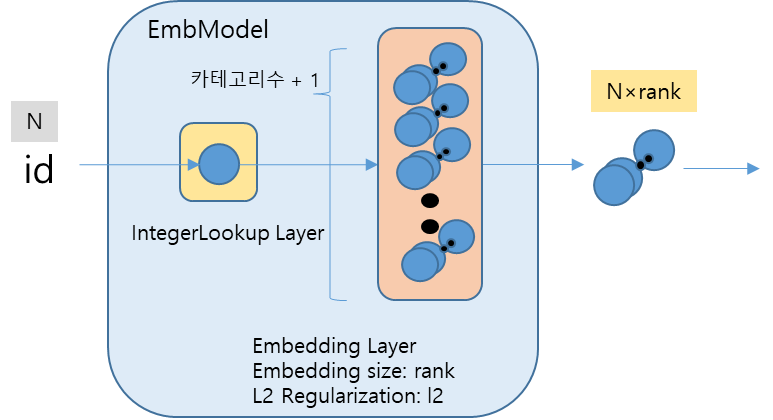

In [ ]:
class EmbModel(tf.keras.Model):
    def __init__(self, ids, rank, l2=0):
        """
        정수형 ID로 된 임베딩을 받아서 임베딩 벡터를 반환시켜 주는 모델
        Parameters: 
            ids: list
                카테고리의 수준들의 id 리스트
            rank: int
                임베딩 벡터의 사이즈
            l2: float
                l2 규제 계수
        """
        super().__init__()
        # 정수형 ID를 1-based Index로 반환해주는 Layer를 만듭니다. - 0은 OOV(out-of-vocabulary)입니다.
        self.lu_ids = tf.keras.layers.IntegerLookup(vocabulary=tf.constant(ids))
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        # Index에 대한 Embedding을 반환하는 Layer를 생성합니다.
        self.emb = tf.keras.layers.Embedding(len(ids) + 1, rank, embeddings_regularizer=reg)
    
    def call(self, x, training=False):
        x = self.lu_ids(x) # 정수형 ID(Nx1) → Embedding Index (N×1)
        return self.emb(x, training=training) # Embedding Index 

**Mean Model Architecture**

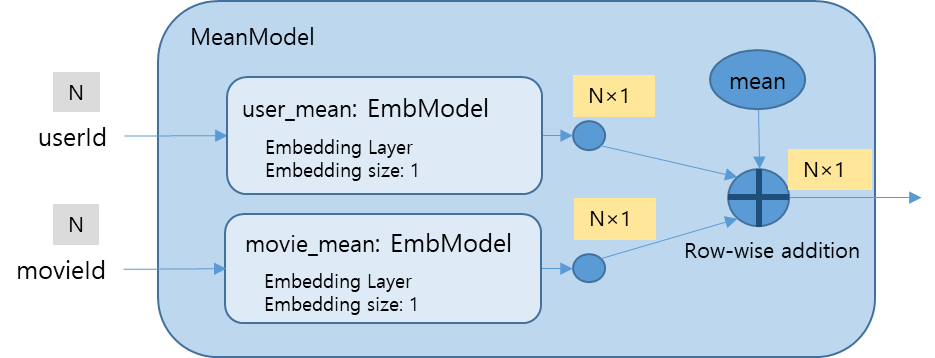

In [ ]:
# 평균, 사용자 평균 모델, 영화 평균 모델을(사이즈가 1인 임베딩 모델) 받아 평균 모델을 구성합니다.
class MeanModel(tf.keras.Model):
    def __init__(self, mean, user_mean_model, movie_mean_model):
        """
        Parameters:
            mean: float
                평균
            user_mean_model: EmbModel
                사용자 평균 모델
            movie_mean_mode: EmbModel
                영화 평균 모델
        """
        super().__init__()
        # 사용자의 평균을 담고 있는 모델을
        self.mean = tf.constant([mean], dtype=tf.float32)
        self.user_mean_model = user_mean_model
        self.movie_mean_model = movie_mean_model
        
    def call(self, x, training=False):
        return self.mean + \
            self.user_mean_model(x['userId'], training=training) + \
            self.movie_mean_model(x['movieId'], training=training)

**Matrix Factorization Model Architecture**

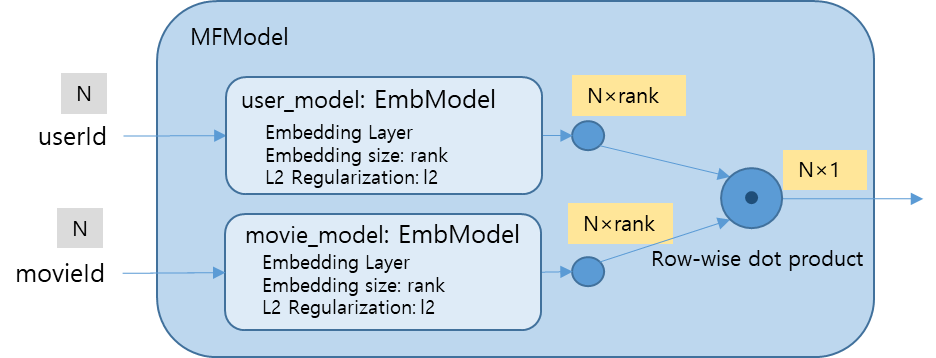

In [ ]:
# 사용자 임베딩 모델과 영화 임베딩 모델을 받아, Matrix Factorization 모델을 구성합니다.
class MFModel(tf.keras.Model):
    def __init__(self, user_model, movie_model):
        """
        Parameters:
            user_model - tf.keras.Model
                사용자 모델
            movie_model - tf.keras.Model
                영화 모델
        """
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.dot = tf.keras.layers.Dot(axes=-1) # axes = -1 로 설정하면 Row-wise(행단위)로 내적 연산을 수행합니다.
    
    def call(self, x, training=False):
        x_user = self.user_model(x['userId'], training=training)
        x_movieId = self.movie_model(x['movieId'], training=training)
        return self.dot([x_user, x_movieId])

**가장 간단한 앙상블 모델로 여러 모델의 Output을 더하여 하나의 Output으로 만듭니다.**

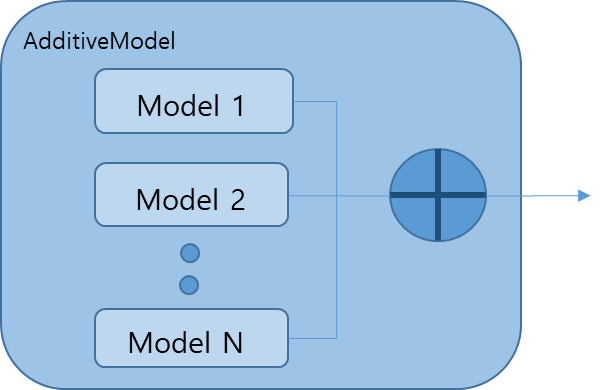

In [ ]:
# 제공한 모델 각각의 예측 결과를 더하는 모델을 만듭니다.
class AdditiveModel(tf.keras.Model):
    def __init__(self, models):
        """
        Parameters:
            models: list
                tf.keras.Model 객체로 이루진 리스트입니다.
        """
        super().__init__()
        self.models = models
        
    def call(self, x, training=False):
        # 각각의 모델에서 나온 출력을 모으기 위한 리스트 입니다.
        y_hat = []
        for i in self.models:
            y_hat.append(i(x, training=training))
        return tf.reduce_sum(y_hat, axis=0)

**성능 평가**

Cold Start Problem 문제와 모델 주기적 재학습 문제가 어떤 양상으로 나타나는지 살펴봅니다.

그래서 train에 사용자/아이템의 등장횟수에 따라 test의 성능이 어떻게 달라지는 지 확인해 봅니다.

In [ ]:
from sklearn.metrics import mean_squared_error

def predict(a_model, ds, batch_size = 1024, verbose=True):
    return np.squeeze(a_model.predict(ds.batch(batch_size), verbose= 1 if verbose else 0))

def train_rcmd_model(a_model, epoches, user_bins, movie_bins, batch_size=1024, prd_batch_size=4096, shuffle_buffer_size=100000, verbose=True):
    """
    모델을 입력 받아 학습을 시킵니다.
    Parameters:
        a_model: tf.keras.model
            추천 모델
        epoches: int int
            최적화 과정의 반복횟수
        user_bins: list
            성능 측정시 사용자 평가 빈도 구간
        movie_bins: list
            성능 측정시 영화 평가 빈도 구간
        batch_size: int
            데이터셋 배치 사이즈
        shuffle_buffer_size: int
            Train Set을 섞어주는 버퍼 사이즈
        verbose: int
            진행 상황 출력
    Returns: DataFrame
        사용자와 영화의 평가 빈도별 모델 검증 결과를 담은 DataFrame
    """
    # epoch 마다 결과를 기록해 놓을 list 입니다.
    mse_train = [] # 학습셋에 대한 mse
    mse_test = [] # 테스트셋에 대한 mse
    mse_by_userCnt = [] # 테스트셋에 대한 성능 사용자가 학습셋에 등장한 횟수에 따른 구간별 mse
    mse_by_movieCnt = [] # 테스트셋에 대한 성능 영화가 학습셋에 등장한 횟수에 따른 구간별 mse
    # 평가 데이터의 userId의 학습데이터의 출현 빈도를 구합니다.
    s_user_type = pd.cut(
        df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
    ).rename('userCnt')
    # 평가 데이터의 movieId의 학습데이터의 출현 빈도를 구합니다.
    s_movie_type = pd.cut(
        df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
    ).rename('movieCnt')
    for epoch in range(epoches):
        # ds_train을 shuffle_buffer_size만큼 섞어서 batch_size만큼
        a_model.fit(ds_train.shuffle(shuffle_buffer_size).batch(batch_size))
        # Train셋의 성능을 확인하기 위해 train셋에 대한 예측을 합니다.
        train_prds = predict(a_model, ds_train, prd_batch_size)
        # Test셋의 예측을 합니다.
        prds = predict(a_model, ds_test, prd_batch_size, False)

        # Train / Test의 성능으 측정하여 기록합니다.
        mse_train.append(mean_squared_error(df_train['rating'], train_prds))
        mse_test.append(mean_squared_error(df_test['rating'], prds))
        
        # Train에 등장한 사용자 빈도수 별로 구분하여 Test의 성능을 측정합니다.
        mse_by_userCnt.append(
            pd.DataFrame({
                'rating': df_test['rating'],
                'prds': prds
            }).groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )

        # Test에 등장한 영화릐 빈도수 별로 구분하여 Test의 성능을 측정합니다.
        mse_by_movieCnt.append(
            pd.DataFrame({
                'rating': df_test['rating'],
                'prds': prds
            }).groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )

        # 사용자의 평점 빈도수 구분한 성능 측정결과와 영화의 평점 빈도수를 구분한 성능 측정결과를 합칩니다.
        df_result = pd.concat([
            pd.DataFrame({('', 'train'): mse_train, ('', 'test'): mse_test}),
            pd.concat(mse_by_userCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
            ).T,
            pd.concat(mse_by_movieCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
            ).T
        ], axis=1)
        df_result.index = np.arange(1, len(df_result) + 1)
        df_result.name = 'epoch'
        if verbose:
            clear_output()
            display(df_result)
    return df_result

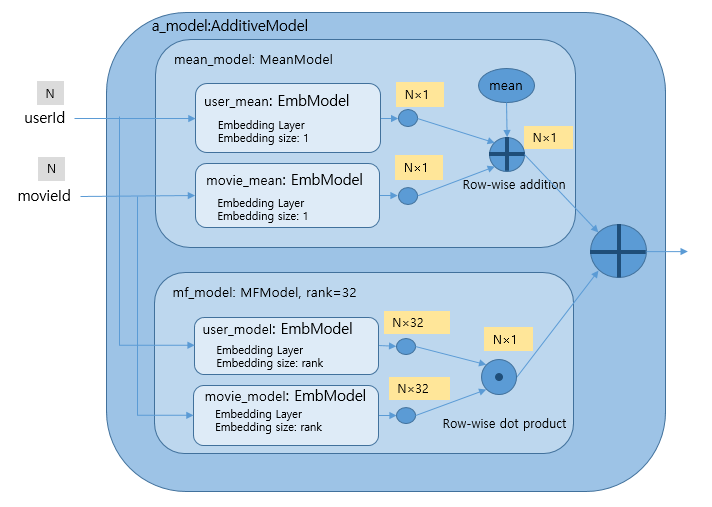

In [ ]:
tf.keras.backend.clear_session()
rank = 32 # 사용자 / 영화 모델의 vector size를 32로 합니다.
# train셋에서 평가 이력이 120건 미만인 사용자에 대해서 임베딩을 사용은 역효과를 보게 되었습니다.
# 따라서, 120건 이상인 사용자를 대상으로 임베딩 벡터를 부여합니다.
user_model = EmbModel(
    s_userCnt.loc[s_userCnt >= 120].index.values, 
    rank
)
# train셋에서 평가 이력이 100건 미만인 영화에 대해서 임베딩을 사용은 역효과를 보게 되었습니다.
# 따라서, 100건 이상인 영화를 대상으로 임베딩 벡터를 부여합니다.
movie_model = EmbModel(
    s_movieCnt.loc[s_movieCnt >= 100].index.values, 
    rank
)
# user_model과 movie_model로 MFModel을 만듭니다.
mf_model = MFModel(user_model, movie_model)
# mf_model의 동작을 확인합니다.
mf_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

In [ ]:
user_mean_model = EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1) # 사용자의 상대적 평균을 나타내는 모델입니다.
movie_mean_model = EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1) # 영화의 상대적 평균을 나타내는 모델입니다.
mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model) # 사용자의 상대적 평균과 영화의 상대적 평균을 나타내는 모델을 MeanModel에 전달합니다.
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

In [ ]:
# 가법 앙상블 모델의 동작을 확인합니다.
a_model = AdditiveModel([mf_model, mean_model])
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

### 사용자의 평가 빈도에 따른 데이터의 분포를 확인합니다.

In [ ]:
# 사용자의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
user_bins = [0, 1, 120, 500, 1000, np.inf]
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
pd.concat([
    s_user_type.value_counts().rename('count'),
    s_user_type.value_counts(normalize=True).rename('ratio')
], axis=1)

### 영화의 평점 빈도에 따른 데이터의 분포를 확인합니다.

In [ ]:
# 영화의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).rename('movieCnt')
pd.concat([
    s_movie_type.value_counts().rename('count'),
    s_movie_type.value_counts(normalize=True).rename('ratio')
], axis=1)

**nvdia-smi** : GPU의 상태를 체크해주는 프로그램

In [ ]:
# mf.pkl 이 없으면 학습을 하고, 학습 산출물를 mf1.pkl에 저장합니다.
# mf.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다,,
if not os.path.isfile('mf.pkl'):
    tf.keras.backend.clear_session()
    rank = 32

    # 모델을 생성합니다.
    user_idx = s_userCnt.loc[s_userCnt > 120].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt > 100].index.values
    user_model = EmbModel(user_idx, rank)
    movie_model = EmbModel(movie_idx, rank)
    mf_model = MFModel(user_model, movie_model)

    user_mean_idx = s_userCnt.loc[s_userCnt > 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt > 1].index.values
    user_mean_model = EmbModel(user_mean_idx, rank=1)
    movie_mean_model = EmbModel(movie_mean_idx, rank=1)
    mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    # mf_model과 mean_model을 AdditiveModel로 결합합니다.
    a_model = AdditiveModel([mf_model, mean_model])
    # Adam Optimizer의 Learning Rate 즉, Gradient로 Weight를 업데이트 할 때의 가중치를 설정이 중요합니다.
    # 적정선 보다 크다면 탐색 공간을 지나치게 빠르게 지나가게 되므로, 최적의 학습정도를 파악하기 어렵고,
    # 적정선 보다 작다면 최적점까지 수렴하기에 많은 연산이 필요합니다.
    # 실험을 통해 얻은 가장 적절한 학습율은 3e-4였습니다.
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    user_bins = [0, 1, 120, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open('mf.pkl', 'wb') as f:
        pickle.dump({
            'rank': rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'result': df_result,
            'weights': a_model.get_weights()
        }, f)
else:
    with open('mf.pkl', 'rb') as f:
        mf = pickle.load(f)
    # 학습 결과를 출력합니다.
    display(mf['result'])
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf['rank']
    user_model = EmbModel(mf['user_idx'], rank)
    movie_model = EmbModel(mf['movie_idx'], rank)
    mf_model = MFModel(user_model, movie_model)
    
    user_mean_model = EmbModel(mf['user_mean_idx'], rank=1)
    movie_mean_model = EmbModel(mf['movie_mean_idx'], rank=1)
    mean_model = MeanModel(mf['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model, mean_model])
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf['weights'])
    del mf

In [ ]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

In [ ]:
log_dir='logs/m25m/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding 항목의 메타 데이터를 기록합니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt >= 100].index:
        f.write("{}\n".format(dic_movie_info_kr.get(i, {'original_title': 'unknown'})['original_title']))

# Embedding을 기록합니다.
weights =  tf.Variable(movie_model.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 임베딩 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
# %tensorboard --logdir logs/m25m/ --bind_all

# Matrix Factorization + Neural Network

**Cold Start Problem** 을 해소하기 위한 가장 효과가 클 만한 요소는 사용자 쪽의 개선입니다. 

왜냐하면, Train에 전혀 등장하지 않은 사용자의 로그가 **77.4%** 이고, 오차 또한 큽니다

사용자의 메타 데이터는 없지만, 사용자가 이전에 평가했던 이력은 Test에서도 1번 이상 평가했던 사용자에게는 유효합니다.

사용자가 이전에 시청한 영화 Embedding과 평점을 사용자 입력에 추가하는 방법을 사용합니다.

사용자 모델을 Embedding을 임베딩 층만을 이용한 것에서 확장하여, 

사용자의 Embedding, 이전 시청 영화의 임베딩, 그리고 이전 영화의 평점을 이용하여 사용자의 잠재 요소(Latent Factor)를 

나타내는 모델을 Neural Netowrk를 이용하여 모델을 만듭니다.

출력을 Matrix Factorization의 Rank로하는 Neural Network을 구성하는 모델로 User의 Embedding을 확장합니다.

## + 사용자가 직전 평가한 영화와 평점

User Model과 평가한 영화와 평점을 Dense Layer를 통해 사용자와 이전 영화 평점에 대한 Embedding 모델을 만듭니다.

- prev movie id: 사용자가 직전 평가한 영화
- prev rating: 사용자가 직전 평가한 영화의 평점

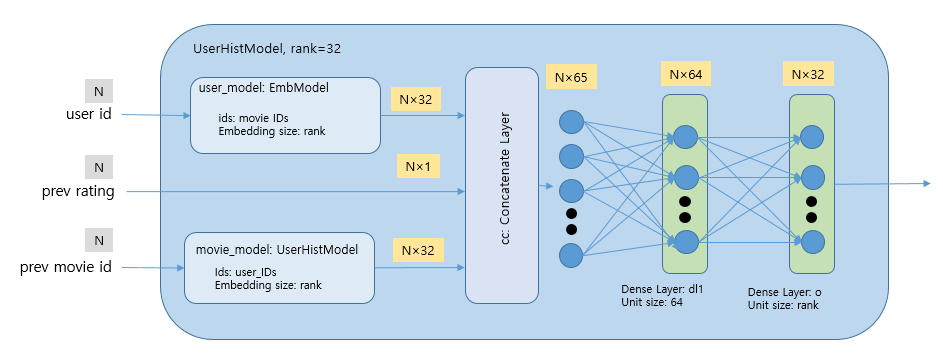

In [ ]:
class UserHistModel(tf.keras.Model):
    """
    사용자가 이전에 평가한 영화와 평점을 입력 받는 모델입니다.
    """
    def __init__(self, user_model, movie_model, rank, l2=0):
        """
        Parameters
            user_model: tf.keras.Model
                사용자 모델
            movie_model: tf.keras.Model
                영화 모델
            rank: int
                출력 벡터의 수
            l2: float
                L2 규제, 0일 때는 규제를 사용하지 않습니다.
        """
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        
        # Rank 벡터를 만들어 내기 위한 밀집 신경망을 구성합니다. 
        # 첫번째 은닉층(1st Hidden Layer )
        self.dl = tf.keras.layers.Dense(
            64, activation='relu', 
            kernel_initializer=tf.keras.initializers.HeNormal(), # relu와 같은 0이상의 값만을 갖는 활성화함수는 초기화 방밥에는 HeNormal이 유용
            kernel_regularizer=reg
        )
        
        # 출력층(Output Layer)
        self.o = tf.keras.layers.Dense(
            rank, 
            kernel_regularizer=reg
        )
        
        # 사용자 벡터, 이전 시청 영화 벡터, 평점을 결합하기 위한 결합층(Concatenate Layer)을 생성합니다.
        self.cc = tf.keras.layers.Concatenate(axis=-1)

    def call(self, x, prev_movieId, prev_rating, training=False):
        vec = self.cc([
            self.user_model(x, training=training), # 사용자 벡터를 가져옵니다. N×rank
            self.movie_model(prev_movieId, training=training), # 이전 시청 영화 벡터를 가져옵니다. N×rank
            tf.expand_dims(
                prev_rating, # N
                axis=-1
            ) # 이전 평점. N×1
        ]) # N×(2×rank + 1)
        
        vec = self.dl(vec) # 첫번째 은닉층. N×64
        return self.o(vec) # 출력층. N×rank

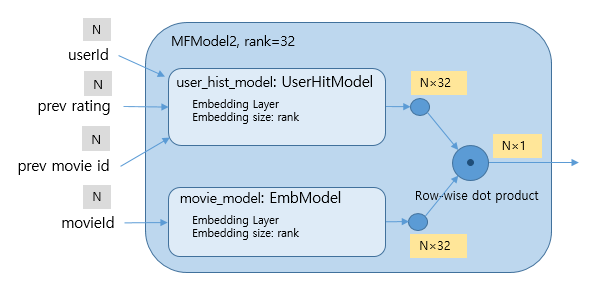

In [ ]:
class MFModel2(tf.keras.Model):
    """
    MFModel에서 UserHistModel에 prev_movidId(이전 시청 영화 ID)와 prev_rating(이전 평점)을 전달 할 수 있도록 업그레이드한 모델입니다.
    """
    def __init__(self, user_hist_model, movie_model):
        super().__init__()
        self.user_hist_model = user_hist_model
        self.movie_model = movie_model
        # Row-wise dot Product를 하도록 설정합니다.
        self.dot = tf.keras.layers.Dot(axes=-1)
    
    def call(self, x, training=False):
        # 사용자 최종 모델 (UserHistModel)에 userId, prev_movieId, prev_rating을 입력하여
        # 사용자 벡터를 가져옵니다.
        x_user = self.user_hist_model(
            x['userId'], # N
            x['prev_movieId'], # N
            x['prev_rating'], # N
            training=training
        ) # N×32
        x_movieId = self.movie_model(
            x['movieId'], # N
            training=training
        ) # N×32
        return self.dot([x_user, x_movieId])

* mf_model2의 동작을 확인합니다.

In [ ]:
tf.keras.backend.clear_session()
rank = 32
user_model = EmbModel( 
    s_userCnt.loc[s_userCnt >= 140].index.values, # 이전의 사용자의 시청 이력을 추가하면서 효용성을 보이는 사용자의 평점수가 140개로 높아졌습니다.
    rank, 
)
movie_model = EmbModel(
    s_movieCnt.loc[s_movieCnt >= 100].index.values, 
    rank, 
)
user_hist_model = UserHistModel(user_model, movie_model, rank)
mf_model2 = MFModel2(user_hist_model, movie_model)
mf_model2({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

In [ ]:
user_mean_model = EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
a_model = AdditiveModel([mf_model2, mean_model])

a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

In [ ]:
user_bins = [0, 1, 140, 500, 1000, np.inf]
# 사용자의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
pd.concat([
    s_user_type.value_counts().rename('count'),
    s_user_type.value_counts(normalize=True).rename('ratio')
], axis=1)

In [ ]:
# mf2.pkl 이 없으면 학습을 하고, 학습 산출물를 mf2.pkl에 저장합니다.
# mf2.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
if not os.path.isfile('mf2.pkl'):
    rank = 32
    user_idx = s_userCnt.loc[s_userCnt > 140].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt > 100].index.values
    user_model = EmbModel(user_idx, rank)
    movie_model = EmbModel(movie_idx, rank)
    user_hist_model = UserHistModel(user_model, movie_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_model)

    user_mean_idx = s_userCnt.loc[s_userCnt > 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt > 1].index.values
    user_mean_model = EmbModel(user_mean_idx, rank=1)
    movie_mean_model = EmbModel(movie_mean_idx, rank=1)
    mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    user_bins = [0, 1, 140, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open('mf2.pkl', 'wb') as f:
        pickle.dump({
            'rank': rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'result': df_result,
            'weights': a_model.get_weights()
        }, f)
else:
    with open('mf2.pkl', 'rb') as f:
        mf2 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf2 = mf2['result']
    display(df_result_mf2)
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf2['rank']
    user_model = EmbModel(mf2['user_idx'], rank)
    movie_model = EmbModel(mf2['movie_idx'], rank)
    user_hist_model = UserHistModel(user_model, movie_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_model)
    
    user_mean_model = EmbModel(mf2['user_mean_idx'], rank=1)
    movie_mean_model = EmbModel(mf2['movie_mean_idx'], rank=1)
    mean_model = MeanModel(mf2['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})
    
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf2['weights'])
    del mf2

### 최종 모델의 평가 데이터에 대한 예측 결과를 구하고, 사용자와 영화의 평점 빈도에 따른 성능을 보입니다.

In [ ]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

## + 영화 컬렉션, 장르, Overview Open AI Embedding 추가

In [ ]:
# 영화를 모델링하기 위한 정보를 만들어 냅니다.

# 우선 genre를 가변수화 합니다.
# 그리고, series 정보를 합칩니다.
df_movieinfo = pd.concat([
    pd.concat([
        s_genre.apply(lambda x: i in x).astype('float32').rename('genre{}'.format(i))
        for i in s_genre.explode().unique()
    ], axis=1), s_series
], axis=1)

df_movieinfo['collection'] = df_movieinfo['collection'].fillna(0).astype(int)
# 영화마다 제목과 줄거리 Embedding을 ov_emb에 저장합니다.
df_movieinfo['ov_emb'] = df_movieinfo.index.to_series().map(movie_info_emb)
# avg_ov_emb: 등장하지 않은 영화의 줄거리 Embedding을 위해 Embedding이 있는 영화릐 평균을 구합니다.
avg_ov_emb = np.mean(
    np.vstack(
        df_movieinfo['ov_emb']
    ), axis=0
)
# df_movieinfo의 첫번째 행은 등장하지 않은 영화를 위한데이터 입니다. 평균 임베딩과 그외 다른 정보는 0으로 입력되게 합니다.
df_movieinfo = pd.concat([
    pd.DataFrame({'ov_emb': [avg_ov_emb], 'collection': [0]}, index=[0]),
    df_movieinfo
], axis=0).fillna(0)

# 테스트 데이터에만 등장한 Series 데이터는 제외 시킵니다.
df_movieinfo.loc[
    ~df_movieinfo['collection'].isin(df_train['movieId'].map(df_movieinfo['collection']).dropna().astype(int).unique()),
    'collection'
] = 0
df_movieinfo

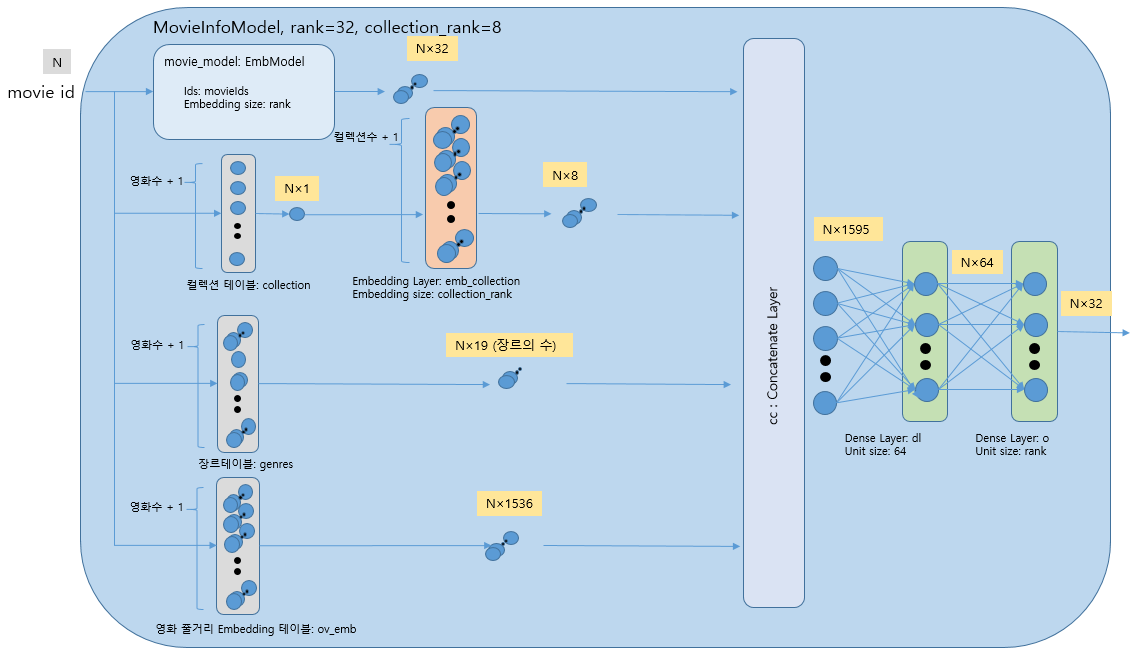

**메타데이터  탑재를 모델에 탑재시킵니다.**

* 영화의 메타데이터를 학습 데이터에 결합을 한다면, 학습 데이터가 커져서 메모리에 담기 어려워 집니다. 
  
  Ex) 사이즈가 1536인 OpenAI 영화 줄거리 임베딩을 학습 데이터에 결합한다면, 2500만 × 1536 × 8 bytes(Float 타입 사이즈) = 약 270GB
  
  이를 모델에 탑재하여 데이터 사이즈의 폭증하는 문제를 해소합니다. 
  
* 영화에 대한 메타데이터를 모델에 포함하여 모델에는 movie id만 전달하기만 하면 되므로, 메타 데이터를 건건히 전달할 필요가 없어 추상화를 통한 네트워크 구성의 간소화를 가져갈 수 있습니다.

→ 영화 장르는  19개의 가변수 형태입니다. 이것을 영화수 x 19의 상수 행렬로 만들어 탑재시킵니다.

→ 영화 줄거리 임베딩은 1536개의 vector입니다. 이것을 영화수 x 1536의 상수 행렬로 만들어 탑재시킵니다.

→ 시리즈 정보는 1개의 정수입니다. 영화수만큼의 벡터로 탑재시킵니다.

IntegerLookup 레이로 movieId에 따른 위치인덱스를 가져와서, 해당 위치의 장르, 줄거리, 시리즈 정보를 탑재된 행렬에서 가져옵니다.

tf.gather: 위치인덱스에 해당하는 텐서를 가져옵니다.

In [ ]:
# 입력 데이터에 메타데이터를 넣으면 2500천만건 × 메타데이터수 만큼(genre 19개, 시리즈 1개, 영화줄거리 임베딩: 1536개) 만큼의 데이터가
# 생기므로, 커다란 용량이 필요합니다. 
# 모델의 아이템의 메타데이터를 탑재시킵니다.

# 우선 장르부터 해봅니다.
# 장르의 가변수명을 가져옵니다. 사용합니다.
cols_genre = [i for i in df_movieinfo.columns if i.startswith('genre')]
# 장르의 가변수를 상수 텐서로 만듭니다.
genres = tf.constant(df_movieinfo[cols_genre])
genres

In [ ]:
# IntegerLookup을 통해 movieId에 대한 위치 인덱스를 가져옵니다.
lu_movie = tf.keras.layers.IntegerLookup(vocabulary=df_movieinfo.index[1:].values)
# movieId가 1, 2 번인 영화의 위치 인덱스를 가져옵니다.
mid = lu_movie(tf.constant([1, 2]))
# tf.gather는 위치에 해당하는 내용을 가져옵니다.
mid, tf.gather(genres, mid)

In [ ]:
df_movieinfo.loc[[1, 2], cols_genre]

In [ ]:
# df_movieinfo['collection']
# 단일 데이터인 시리즈를 tf.constant로 만듭니다.
collection = tf.constant(df_movieinfo['collection'])
# 영화 줄거리 Embedding을 tf.constant로 만듭니다. df_movieinfo['ov_emb']
ov_emb = tf.constant(df_movieinfo['ov_emb'].tolist())
# 영화에 대한 데이터가 저장된 위치 인덱스를 가져옵니다.

tf.gather(collection, mid), tf.gather(ov_emb, mid)

In [ ]:
df_movieinfo.loc[[1, 2], 'collection']

In [ ]:
df_movieinfo.loc[[1, 2], 'ov_emb']

In [ ]:
class MovieInfoModel(tf.keras.Model):
    def __init__(self, df_movieinfo, movie_model, emb_config, rank, l2=0):
        super().__init__()
        self.lu_movie = tf.keras.layers.IntegerLookup(vocabulary=df_movieinfo.index[1:].values)
        # 영화 별 장르 정보를 담고 저장공간생성
        cols_genre = [i for i in df_movieinfo.columns if i.startswith('genre')]
        self.genres = tf.constant(df_movieinfo[cols_genre])
        # 영화의 컬렉션 정보를 지니고 있는 저장공간 생성
        self.collection = tf.constant(df_movieinfo['collection'])
        # 영화의 제목 + 줄거리의 OpenAI에서 구한 Embedding 정보 저장공간 생성
        self.ov_emb = tf.constant(df_movieinfo['ov_emb'].tolist())
        self.movie_model = movie_model
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        self.emb_collection = tf.keras.layers.Embedding(
            df_movieinfo['collection'].max() + 1, 
            emb_config['collection'], 
            embeddings_regularizer=reg
        )

        # 은닉레이어 1: Dense(64)
        self.dl = tf.keras.layers.Dense(
            64, activation='relu', 
            kernel_initializer=tf.keras.initializers.HeNormal(), 
            kernel_regularizer=reg
        )
        # 출력 레이어: Dense(rank)
        self.o = tf.keras.layers.Dense(rank)
        # 결합 레이어
        self.cc = tf.keras.layers.Concatenate(axis=-1)
    
    def call(self, x, training=False):
        x_movie = self.movie_model(x, training=training)
        
        x = self.lu_movie(x)
        x_genre = tf.gather(self.genres, x)
        x_collection = tf.gather(self.collection, x) 
        x_collection =self.emb_collection(x_collection, training=training)
        x_ov_emb = tf.gather(self.ov_emb, x)
        x = self.cc([x_movie, x_genre, x_collection, x_ov_emb])
        x = self.dl(x)
        return self.o(x)

- mf2_model의 동작을 확인하고, mean_model과 앙상블 모델을 구성하여 최종 동작을 합니다.

In [ ]:
tf.keras.backend.clear_session()
rank = 32
collection_rank = 8
user_model = EmbModel(s_userCnt.loc[s_userCnt >= 140].index.values, rank)
movie_model = EmbModel(s_movieCnt.loc[s_movieCnt >= 100].index.values, rank)
movie_info_model = MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
user_hist_model = UserHistModel(user_model, movie_info_model, rank)
mf_model2 = MFModel2(user_hist_model, movie_info_model)
mf_model2({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

In [ ]:
user_mean_model = EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

In [ ]:
a_model = AdditiveModel([mf_model2, mean_model])
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]),
        'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

In [ ]:
# mf2_2.pkl 이 없으면 학습을 하고, 학습 산출물를 mf2_2.pkl에 저장합니다.
# mf2_2.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
if not os.path.isfile('mf2_2.pkl'):
    rank = 32
    collection_rank = 8
    user_idx = s_userCnt.loc[s_userCnt > 140].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt > 100].index.values
    user_model = EmbModel(user_idx, rank)
    movie_model = EmbModel(movie_idx, rank)
    movie_info_model = MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
    user_hist_model = UserHistModel(user_model, movie_info_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_info_model)

    user_mean_idx = s_userCnt.loc[s_userCnt > 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt > 1].index.values
    user_mean_model = EmbModel(user_mean_idx, rank=1)
    movie_mean_model = EmbModel(movie_mean_idx, rank=1)
    mean_model = MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    user_bins = [0, 1, 140, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open('mf2_2.pkl', 'wb') as f:
        pickle.dump({
            'rank': rank,
            'collection_rank': collection_rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'movieinfo': df_movieinfo,
            'result': df_result,
            'weights': a_model.get_weights()
        }, f)
else:
    with open('mf2_2.pkl', 'rb') as f:
        mf2_2 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf2_2 = mf2_2['result']
    display(df_result_mf2_2)
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf2_2['rank']
    collection_rank = mf2_2['collection_rank']
    user_model = EmbModel(mf2_2['user_idx'], rank)
    movie_model = EmbModel(mf2_2['movie_idx'], rank)
    movie_info_model = MovieInfoModel(mf2_2['movieinfo'], movie_model, {'collection': collection_rank}, rank)
    user_hist_model = UserHistModel(user_model, movie_info_model, rank)
    mf_model2 = MFModel2(user_hist_model, movie_info_model)
    
    user_mean_model = EmbModel(mf2_2['user_mean_idx'], rank=1)
    movie_mean_model = EmbModel(mf2_2['movie_mean_idx'], rank=1)
    mean_model = MeanModel(mf2_2['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = AdditiveModel([mf_model2, mean_model])
    
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})
    
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf2_2['weights'])
    del mf2_2

In [ ]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

In [ ]:
log_dir='logs/m25m_2/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding 메타 데이터를 기록합니다.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt > 100].index:
        if i in df_movieinfo.index:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)
        
# Embedding을 기록합니다.
weights =  tf.Variable(movie_info_model(tf.constant(known)))
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 임베딩 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
# %tensorboard --logdir logs/m25m_2/ --bind_all